In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.fftpack
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
df_2019 = pd.read_csv("2019_full_data.csv", index_col=0, parse_dates=True)
df_2019_backup = df_2019.copy()
df_2019

,PERIOD,WEP ($/MWh),USEP ($/MWh),DEMAND (MW),GROSS INJECTION (MWh),NET INJECTION (MWh)
DATE,,,,,,
2019-01-01 00:00:00,1,83.33,82.70,5201.890,2555.100,2362.296
2019-01-01 00:30:00,2,83.83,82.71,5150.461,2549.410,2357.615
2019-01-01 01:00:00,3,83.19,82.70,5106.794,2519.013,2327.042
2019-01-01 01:30:00,4,83.13,82.69,5075.841,2492.473,2300.457
2019-01-01 02:00:00,5,83.20,82.67,5044.147,2453.576,2261.511
...,...,...,...,...,...,...
2019-12-31 21:30:00,44,75.21,75.60,5891.368,2926.282,2744.409
2019-12-31 22:00:00,45,72.43,72.47,5763.008,2857.822,2676.250
2019-12-31 22:30:00,46,69.58,69.45,5665.323,2805.823,2624.380


In [4]:
#Replace outlier with upper limit
std = df_2019['WEP ($/MWh)'].std()
mean = df_2019['WEP ($/MWh)'].mean()

In [5]:
df_2019_WEP = df_2019.filter(['WEP ($/MWh)'], axis=1)
df_2019_WEP['WEP ($/MWh)'].loc[df_2019_WEP['WEP ($/MWh)'] > mean + 3*std] = mean + 3*std

                         PERIOD  WEP ($/MWh)  USEP ($/MWh)  DEMAND (MW)  \
PERIOD                 1.000000     0.206671      0.143468     0.538817   
WEP ($/MWh)            0.206671     1.000000      0.821367     0.371207   
USEP ($/MWh)           0.143468     0.821367      1.000000     0.254471   
DEMAND (MW)            0.538817     0.371207      0.254471     1.000000   
GROSS INJECTION (MWh)  0.555030     0.378554      0.260156     0.995496   
NET INJECTION (MWh)    0.561097     0.374491      0.257451     0.992566   

                       GROSS INJECTION (MWh)  NET INJECTION (MWh)  
PERIOD                              0.555030             0.561097  
WEP ($/MWh)                         0.378554             0.374491  
USEP ($/MWh)                        0.260156             0.257451  
DEMAND (MW)                         0.995496             0.992566  
GROSS INJECTION (MWh)               1.000000             0.995957  
NET INJECTION (MWh)                 0.995957             1.000000 

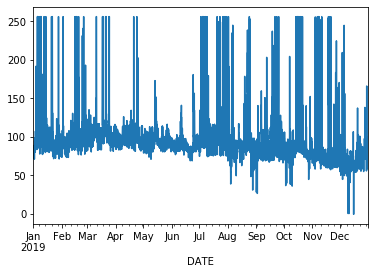

In [6]:
df_2019['WEP ($/MWh)']=df_2019_WEP['WEP ($/MWh)']
print (df_2019.corr())
df_2019['WEP ($/MWh)'].plot()

In [7]:
df_2019_WEP.columns=['WEP']
df_2019_WEP

,WEP
DATE,
2019-01-01 00:00:00,83.33
2019-01-01 00:30:00,83.83
2019-01-01 01:00:00,83.19
2019-01-01 01:30:00,83.13
2019-01-01 02:00:00,83.20
...,...
2019-12-31 21:30:00,75.21
2019-12-31 22:00:00,72.43
2019-12-31 22:30:00,69.58


In [8]:
values = df_2019_WEP.values
data = series_to_supervised(values, 336, 1, False)
data.index = df_2019_WEP.index
data['PERIOD']=df_2019['PERIOD']
data['day_of_week'] = data.index.dayofweek
data['WEP']=data['var1(t)']
final_data=data.drop('var1(t)',1).dropna()
final_data.to_csv("MLP.csv",index=False)
final_data


,var1(t-336),var1(t-335),var1(t-334),var1(t-333),var1(t-332),var1(t-331),var1(t-330),var1(t-329),var1(t-328),var1(t-327),...,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),PERIOD,day_of_week,WEP
DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-08 00:00:00,83.33,83.83,83.19,83.13,83.20,78.81,78.30,73.55,73.65,73.41,...,129.44,113.88,106.44,95.68,98.96,92.03,77.90,1,1,89.81
2019-01-08 00:30:00,83.83,83.19,83.13,83.20,78.81,78.30,73.55,73.65,73.41,73.46,...,113.88,106.44,95.68,98.96,92.03,77.90,89.81,2,1,87.82
2019-01-08 01:00:00,83.19,83.13,83.20,78.81,78.30,73.55,73.65,73.41,73.46,73.65,...,106.44,95.68,98.96,92.03,77.90,89.81,87.82,3,1,88.63
2019-01-08 01:30:00,83.13,83.20,78.81,78.30,73.55,73.65,73.41,73.46,73.65,73.38,...,95.68,98.96,92.03,77.90,89.81,87.82,88.63,4,1,89.57
2019-01-08 02:00:00,83.20,78.81,78.30,73.55,73.65,73.41,73.46,73.65,73.38,73.29,...,98.96,92.03,77.90,89.81,87.82,88.63,89.57,5,1,88.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 21:30:00,76.04,75.89,84.97,81.32,75.47,71.17,68.55,68.06,66.86,66.35,...,76.13,79.69,79.62,79.21,79.40,79.94,78.58,44,1,75.21
2019-12-31 22:00:00,75.89,84.97,81.32,75.47,71.17,68.55,68.06,66.86,66.35,66.36,...,79.69,79.62,79.21,79.40,79.94,78.58,75.21,45,1,72.43
2019-12-31 22:30:00,84.97,81.32,75.47,71.17,68.55,68.06,66.86,66.35,66.36,65.97,...,79.62,79.21,79.40,79.94,78.58,75.21,72.43,46,1,69.58


In [9]:
#df_2019_WEP.reset_index().drop("DATE",1).to_csv("train_simple.csv")

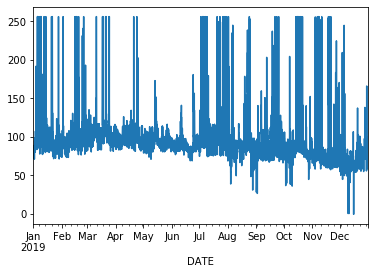

In [10]:
df_2019_WEP['WEP'].plot()